## Aggregate all data collected over all models

In [40]:
import pandas as pd
import os

In [41]:
data_dir = "/home/max/Studium/Leipzig/Semester6/Math_and_ML/math-ml/classifier/data"
list_data = os.listdir(data_dir)

In [42]:
dataframes = []
sum_len = 0
for results_file in list_data:
    df = pd.read_csv(os.path.join(data_dir, results_file))
    data = df[["entropy", "cosine", "correct"]]
    #print(f"Before removing buggy samples: {len(data)=}")
    data = data[data['correct'] != 'buggy']
    #print(f"After removing buggy samples{len(data)=}")
    sum_len += len(data)
    dataframes.append(data)

aggregated_data = pd.concat(dataframes, ignore_index=True)
print(f"{sum_len=} and {len(aggregated_data)=} should be the same.")

sum_len=11950 and len(aggregated_data)=11950 should be the same.


## Prepare data

In [43]:
from sklearn.model_selection import train_test_split
import copy

In [44]:
df = copy.deepcopy(aggregated_data)

In [45]:
df.head(2)

,entropy,cosine,correct
0,0.0,1.0,yes
1,0.0,1.0,yes


In [46]:
#yes => 1, no => 0
df['correct'] = df['correct'].map({'no': 0, 'yes': 1})
df.head(2)

,entropy,cosine,correct
0,0.0,1.0,1
1,0.0,1.0,1


In [47]:
# Select features and target
X = df[["entropy", "cosine"]].values
y = df["correct"].values
print(f"{X.shape=}")
print(f"{y.shape=}")

X.shape=(11950, 2)
y.shape=(11950,)


In [48]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"{len(X_train)=}")
print(f"{len(X_test)=}")
print(f"{len(y_train)=}")
print(f"{len(y_test)=}")

len(X_train)=10755
len(X_test)=1195
len(y_train)=10755
len(y_test)=1195


In [49]:
#investigate data imbalance
print(f"{len(X_train)=} (before SMOTE)")
print(f"{sum(y_train==1)=} positives")
print(f"{sum(y_train==0)=} negatives")

len(X_train)=10755 (before SMOTE)
sum(y_train==1)=np.int64(2132) positives
sum(y_train==0)=np.int64(8623) negatives


In [50]:
#balance data using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"{len(X_train_resampled)=} (after SMOTE)")
print(f"{sum(y_train_resampled==1)=} positives")
print(f"{sum(y_train_resampled==0)=} negatives")

len(X_train_resampled)=17246 (after SMOTE)
sum(y_train_resampled==1)=np.int64(8623) positives
sum(y_train_resampled==0)=np.int64(8623) negatives


## Train the xgboost classifier

In [51]:
import xgboost as xgb

In [52]:
# Train XGBoost classifier
model = xgb.XGBClassifier(eval_metric="logloss")
model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [53]:
# Train a second classifier that does not use the SMOTE data but instead xgboost scale_pos_weight
scale_weight = sum(y_train==0) / sum(y_train==1) # Calculate weight = (# negative) / (# positive)
print(scale_weight)
model_weighted = xgb.XGBClassifier(scale_pos_weight=scale_weight,eval_metric="logloss")
model_weighted.fit(X_train, y_train)

4.044559099437148


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluation

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

**Classifier 1 using SMOTE**

In [55]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [56]:
classification_rep = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
feature_importance = model.feature_importances_

print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Feature Importances:", feature_importance)
print(f"Accuracy = {(conf_matrix[0][0] + conf_matrix[1][1]) / sum(sum(conf_matrix))}")

ROC AUC: 0.7972549500183821
Confusion Matrix:
 [[689 267]
 [ 45 194]]
Feature Importances: [0.22526911 0.77473086]
Accuracy = 0.7389121338912134


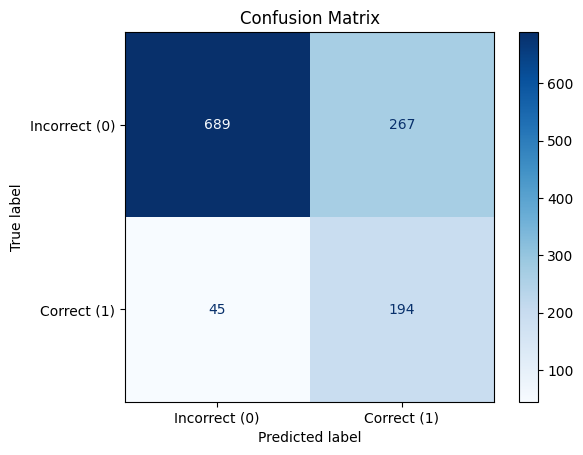

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Plot Confusion Matrix
labels = ['Incorrect (0)', 'Correct (1)']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

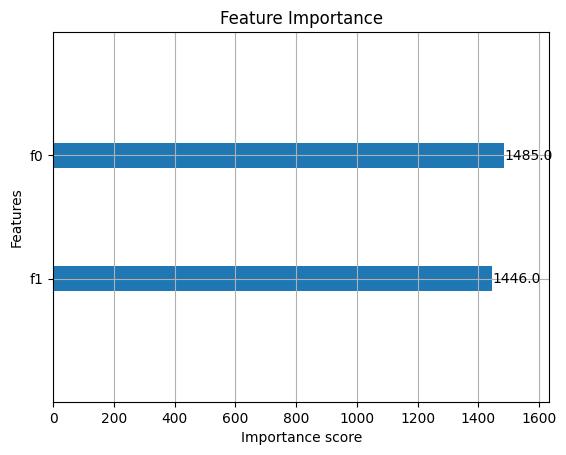

In [58]:
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

**Classifier 2 using the weighted positive samples from xgboost**

In [59]:
# Predict and evaluate
y_pred = model_weighted.predict(X_test)
y_prob = model_weighted.predict_proba(X_test)[:, 1]

In [60]:
classification_rep = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
feature_importance = model.feature_importances_

print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Feature Importances:", feature_importance)
print(f"Accuracy = {(conf_matrix[0][0] + conf_matrix[1][1]) / sum(sum(conf_matrix))}")

ROC AUC: 0.7905170602755553
Confusion Matrix:
 [[694 262]
 [ 48 191]]
Feature Importances: [0.22526911 0.77473086]
Accuracy = 0.7405857740585774


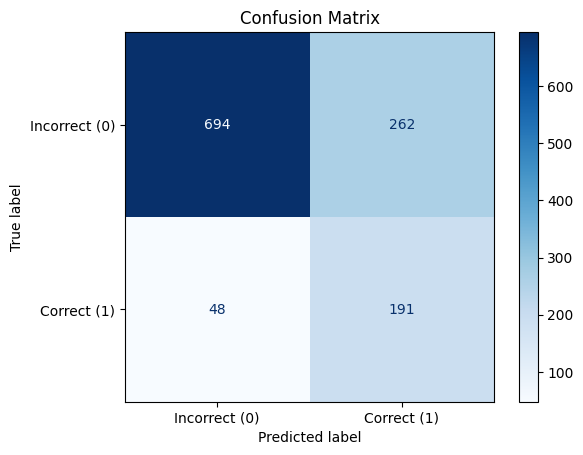

In [61]:
# Plot Confusion Matrix
labels = ['Incorrect (0)', 'Correct (1)']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

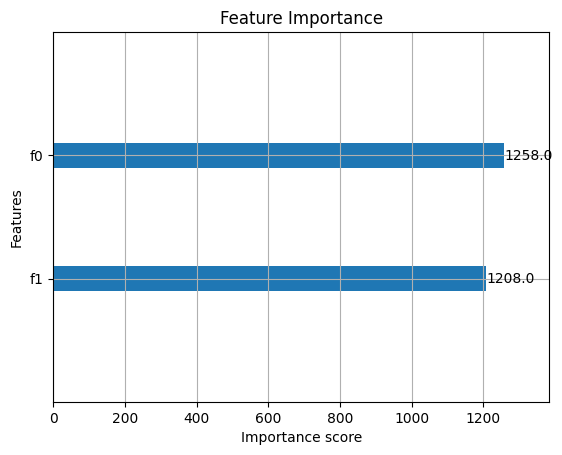

In [62]:
xgb.plot_importance(model_weighted)
plt.title("Feature Importance")
plt.show()

## Evaluate single feature classifier (entropy vs. cosine)

In [63]:
X_train.shape

(10755, 2)

In [64]:
X_train_entropy = X_train[:, [0]]  # shape: (n_samples, 1)
X_train_cosine  = X_train[:, [1]]
print(f"{X_train_entropy.shape=}")
print(f"{X_train_cosine.shape=}")

X_train_entropy.shape=(10755, 1)
X_train_cosine.shape=(10755, 1)


In [65]:
scale_weight = sum(y_train==0) / sum(y_train==1) # Calculate weight = (# negative) / (# positive)
print(scale_weight)

4.044559099437148


In [66]:
model_entropy = xgb.XGBClassifier(scale_pos_weight=scale_weight, eval_metric="logloss")
model_entropy.fit(X_train_entropy, y_train)

model_cosine = xgb.XGBClassifier(scale_pos_weight=scale_weight, eval_metric="logloss")
model_cosine.fit(X_train_cosine, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [68]:
# Predict and evaluate
X_test_entropy = X_test[:, [0]]
print(X_test_entropy.shape)
X_test_cosine  = X_test[:, [1]]
print(X_test_cosine.shape)

y_pred_ent = model_entropy.predict(X_test_entropy)
y_prob_ent = model_entropy.predict_proba(X_test_entropy)[:, 1]
y_pred_cos = model_cosine.predict(X_test_cosine)
y_prob_cos = model_cosine.predict_proba(X_test_cosine)[:, 1]

(1195, 1)
(1195, 1)


**entropy**

In [69]:
classification_rep = classification_report(y_test, y_pred_ent, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred_ent)
roc_auc = roc_auc_score(y_test, y_prob_ent)
feature_importance = model_entropy.feature_importances_

print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Feature Importances:", feature_importance)
print(f"Accuracy = {(conf_matrix[0][0] + conf_matrix[1][1]) / sum(sum(conf_matrix))}")

ROC AUC: 0.7894732235079919
Confusion Matrix:
 [[705 251]
 [ 54 185]]
Feature Importances: [1.]
Accuracy = 0.7447698744769874


**cosine**

In [70]:
classification_rep = classification_report(y_test, y_pred_cos, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred_cos)
roc_auc = roc_auc_score(y_test, y_pred_cos)
feature_importance = model_cosine.feature_importances_

print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Feature Importances:", feature_importance)
print(f"Accuracy = {(conf_matrix[0][0] + conf_matrix[1][1]) / sum(sum(conf_matrix))}")

ROC AUC: 0.75836820083682
Confusion Matrix:
 [[702 254]
 [ 52 187]]
Feature Importances: [1.]
Accuracy = 0.7439330543933055
